# Carregando e preparando dados

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import sys
from tqdm import tqdm

sys.path.append("../")
pd.options.display.max_colwidth = 50
sns.set_style("whitegrid")


In [2]:
candidates_file_path = "../data/processed/se_candidates_output_3.csv"
raw_cand_df = pd.read_csv(candidates_file_path, sep=";", encoding="utf-8")

print(raw_cand_df.shape)
raw_cand_df.info()

(1250, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     1250 non-null   object 
 1   HH_GERACAO                     1250 non-null   object 
 2   ANO_ELEICAO                    1250 non-null   int64  
 3   CD_TIPO_ELEICAO                1250 non-null   int64  
 4   NM_TIPO_ELEICAO                1250 non-null   object 
 5   NR_TURNO                       1250 non-null   int64  
 6   CD_ELEICAO                     1250 non-null   int64  
 7   DS_ELEICAO                     1250 non-null   object 
 8   DT_ELEICAO                     1250 non-null   object 
 9   TP_ABRANGENCIA                 1250 non-null   object 
 10  SG_UF                          1250 non-null   object 
 11  SG_UE                          1250 non-null   object 
 12  NM_UE                          1250 n

In [3]:
tweets_file_path = (
    "../data/processed/sp_elected_stdep_tweets_all_time-ft_hf_classified.csv"
)
raw_tweets_df = pd.read_csv(tweets_file_path, sep=";", encoding="utf-8")

print(raw_tweets_df.shape)
raw_tweets_df.info()

(46973, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46973 entries, 0 to 46972
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46973 non-null  object 
 1   date                      46973 non-null  object 
 2   content                   46973 non-null  object 
 3   user                      46973 non-null  object 
 4   reply_count               46973 non-null  int64  
 5   retweet_count             46973 non-null  int64  
 6   like_count                46973 non-null  int64  
 7   quote_count               46973 non-null  int64  
 8   in_reply_to_id            43445 non-null  float64
 9   in_reply_to_user          43328 non-null  object 
 10  conversation_id           46973 non-null  object 
 11  conversation_user         46973 non-null  object 
 12  ru_bert_base_label        46973 non-null  bool   
 13  ru_bert_base_score        46973 non-null  float64

In [4]:
# Mantendo cópia dos datasets iniciais
cand_df = raw_cand_df
tweets_df = raw_tweets_df


## Dataset de Candidatos

In [5]:
# Removendo colunas não utilizadas
cand_cols = [
    "SG_UF",
    "DS_CARGO",
    "SQ_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "NM_MUNICIPIO_NASCIMENTO",
    "NR_IDADE_DATA_POSSE",
    "DS_GENERO",
    "DS_GRAU_INSTRUCAO",
    "DS_ESTADO_CIVIL",
    "DS_COR_RACA",
    "DS_OCUPACAO",
    "DS_SIT_TOT_TURNO",
    "ST_REELEICAO",
    "TW_USER",
    "TW_followersCount",
    "TW_friendsCount",
    "TW_statusesCount",
    "TW_favouritesCount",
]
cand_df = cand_df[cand_cols]
print(cand_df.shape)

(1250, 20)


In [6]:
# Filtrando somente os deputados estaduais de SP
cand_df = cand_df[cand_df["SG_UF"] == "SP"]
cand_df = cand_df[cand_df["DS_CARGO"] == "DEPUTADO ESTADUAL"]
cand_df.shape

(306, 20)

In [7]:
# Convertendo usernames para minusculo
cand_df["TW_USER"] = cand_df["TW_USER"].str.lower()

In [8]:
cand_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 2 to 1249
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SG_UF                    306 non-null    object 
 1   DS_CARGO                 306 non-null    object 
 2   SQ_CANDIDATO             306 non-null    int64  
 3   NM_URNA_CANDIDATO        306 non-null    object 
 4   NR_PARTIDO               306 non-null    int64  
 5   SG_PARTIDO               306 non-null    object 
 6   NM_MUNICIPIO_NASCIMENTO  306 non-null    object 
 7   NR_IDADE_DATA_POSSE      306 non-null    float64
 8   DS_GENERO                306 non-null    object 
 9   DS_GRAU_INSTRUCAO        306 non-null    object 
 10  DS_ESTADO_CIVIL          306 non-null    object 
 11  DS_COR_RACA              306 non-null    object 
 12  DS_OCUPACAO              306 non-null    object 
 13  DS_SIT_TOT_TURNO         306 non-null    object 
 14  ST_REELEICAO             

## Dataset de Tweets

In [9]:
tweets_df.columns

Index(['url', 'date', 'content', 'user', 'reply_count', 'retweet_count',
       'like_count', 'quote_count', 'in_reply_to_id', 'in_reply_to_user',
       'conversation_id', 'conversation_user', 'ru_bert_base_label',
       'ru_bert_base_score', 'ru_bert_large_label', 'ru_bert_large_score',
       'ru_mdeberta_base_label', 'ru_mdeberta_base_score',
       'ci_distilbert_base_label', 'ci_distilbert_base_score', 'label_sum',
       'ft_rc_bert_base_label', 'ft_rc_bert_base_score'],
      dtype='object')

In [10]:
# Removendo colunas não utilizadas
# Vamos considerar somente a classificação do modelo refinado
tweet_cols = [
    "url",
    "date",
    "content",
    "user",
    "in_reply_to_user",
    "conversation_user",
    "reply_count",
    "retweet_count",
    "like_count",
    "quote_count",
    "ft_rc_bert_base_label",
    "ft_rc_bert_base_score",
]
tweets_df = tweets_df[tweet_cols]
print(tweets_df.shape)

(46973, 12)


In [19]:
tweets_df.rename(columns={
    "ft_rc_bert_base_label": "class_label", 
    "ft_rc_bert_base_score": "class_score"
}, inplace=True)

In [21]:
# Convertendo a coluna de data para o tipo correto
tweets_df.date = pd.to_datetime(tweets_df.date)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46919 entries, 0 to 46972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   url                46919 non-null  object             
 1   date               46919 non-null  datetime64[ns, UTC]
 2   content            46919 non-null  object             
 3   user               46919 non-null  object             
 4   in_reply_to_user   43328 non-null  object             
 5   conversation_user  46919 non-null  object             
 6   reply_count        46919 non-null  int64              
 7   retweet_count      46919 non-null  int64              
 8   like_count         46919 non-null  int64              
 9   quote_count        46919 non-null  int64              
 10  class_label        46919 non-null  bool               
 11  class_score        46919 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(1)

In [22]:
# Filtrando somente os tweets do período desejado
local_tz = pytz.timezone("America/Sao_Paulo")
since = datetime(year=2022, month=9, day=1, tzinfo=local_tz)
until = datetime(year=2022, month=11, day=1, tzinfo=local_tz)

tweets_df = tweets_df[(tweets_df["date"] >= since) & (tweets_df["date"] <= until)]
tweets_df.shape

(46919, 12)

In [23]:
# Removendo tweets com informação faltando de reply
# Se 'user' é diferente de 'conversation_user', então o tweet deveria ter também 'in_reply_to_user'
# Se não tiver, é por que houve algum erro durante o scraping, ou com o tweet respondido
tweets_df = tweets_df[
    ~(
        (tweets_df["in_reply_to_user"].isnull())
        & (tweets_df["user"] != tweets_df["conversation_user"])
    )
]
tweets_df.shape

(46919, 12)

In [24]:
# Convertendo usernames para minusculo
tweets_df.user = tweets_df.user.str.lower()
tweets_df.conversation_user = tweets_df.conversation_user.str.lower()
tweets_df.in_reply_to_user = tweets_df.in_reply_to_user.str.lower()

## Juntando os datasets

In [25]:
df = pd.merge(
    tweets_df, cand_df, left_on="conversation_user", right_on="TW_USER", how="left"
)
df.shape

(46919, 32)

In [26]:
# Adicionando coluna para indicar se o tweet foi postado por um candidate
deputies_usernames = list(df.TW_USER.str.lower().unique())
df["user_is_candidate"] = df["user"].apply(lambda u: u in deputies_usernames)
df["user_is_candidate"].value_counts()

False    41832
True      5087
Name: user_is_candidate, dtype: int64

# Exploração dos dados

<Axes: xlabel='user_is_candidate', ylabel='count'>

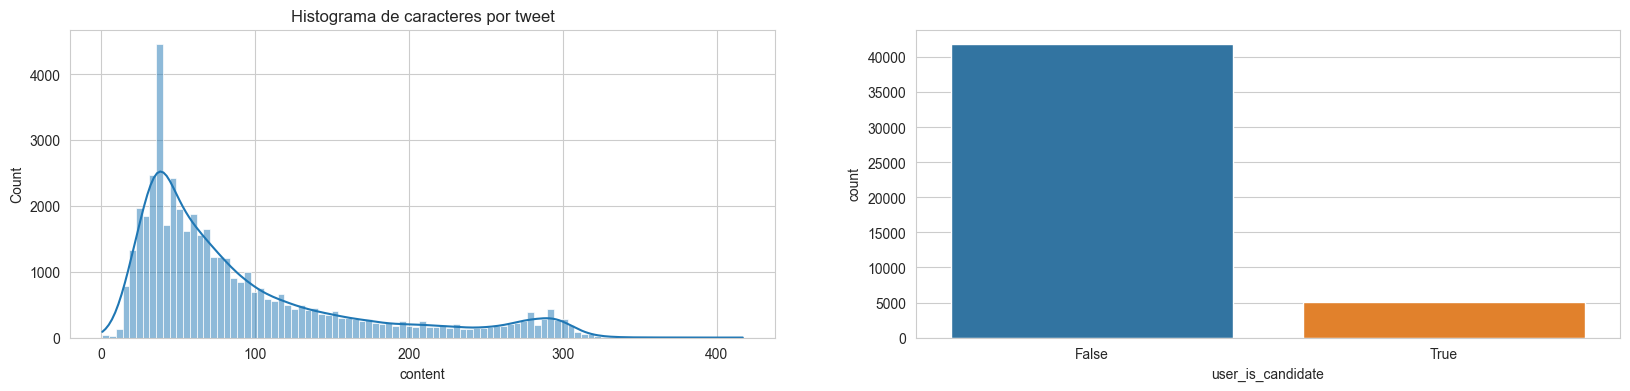

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.histplot(
    df.content.str.len(),
    ax=ax[0],
    kde=True,
).set(title="Histograma de caracteres por tweet")

sns.countplot(
    df,
    x="user_is_candidate", 
    ax=ax[1]
)

In [78]:
# Avaliando a proporção de tweets por candidatos
print(df["user_is_candidate"].value_counts(normalize=True))

False    0.891579
True     0.108421
Name: user_is_candidate, dtype: float64


[Text(0.5, 1.0, 'Histograma de score das classificações')]

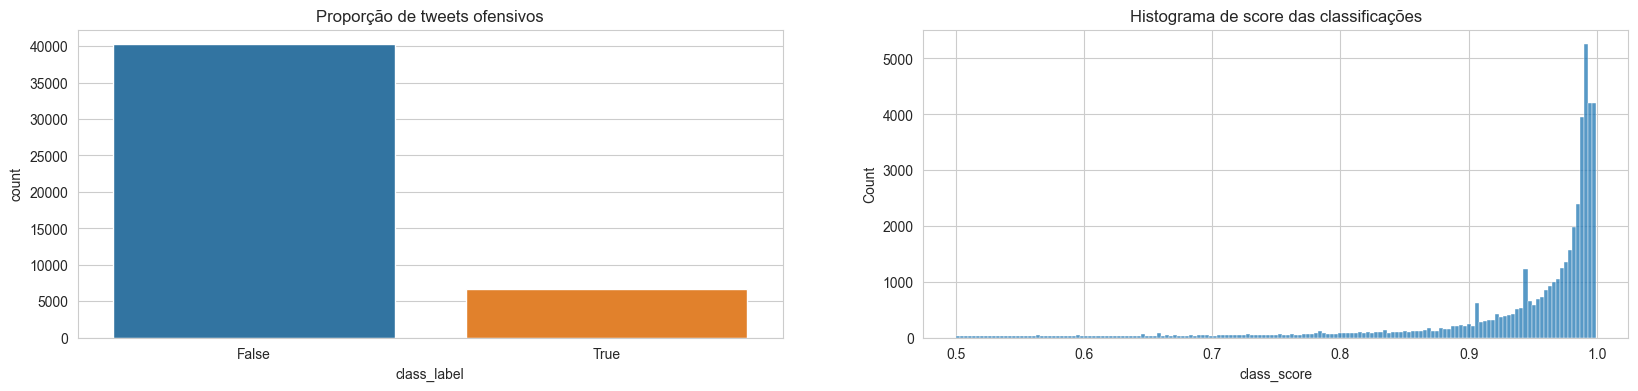

In [81]:
# Avaliando a distribuição e score de ofensas no dataset
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.countplot(
    df,
    x="class_label", 
    ax=ax[0],
).set(title="Proporção de tweets ofensivos")

sns.histplot(
    df.class_score,
    ax=ax[1],
).set(title="Histograma de score das classificações")

In [80]:
print(df["class_label"].value_counts(normalize=True))

False    0.858011
True     0.141989
Name: class_label, dtype: float64


In [39]:
# Checando tweets com conteúdo igual, que acontece principalmente em dois cenários:
# - Vários usuários postando exatamente a mesma mensagem para um candidato
# - Um usuário postando exatamente a mesma mensagem para vários candidatos diferentes
repeated_tweets = (df.content.value_counts() > 1).loc[lambda x: x == True].index
repeated_tweets = df[df['content'].isin(repeated_tweets)]
indexes = repeated_tweets.content.sort_values().index
repeated_tweets = repeated_tweets.reindex(indexes)
repeated_tweets.shape

(2743, 33)

## Calculando e analisando métricas

### Métricas de uso e engajamento

In [55]:
def get_tweets(user):
    """Quantidade de tweets postados pelo usuário"""
    user_df = df[df['user'] == user]
    return user_df.shape[0]

def get_replies(user):
    """Quantidade de replies (respostas diretas) recebidas pelo usuário"""
    user_df = df[df['in_reply_to_user'] == user]
    return user_df.shape[0]

def get_conversation_tweets(user):
    """Quantidade de tweets postados em threads (conversas iniciadas por um novo tweet) criadas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    return user_df.shape[0]

def get_threads(user):
    """Quantidade de threads (conversas iniciadas por um novo tweet) criadas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    threads = user_df[user_df['in_reply_to_user'].isna()]
    return threads.shape[0]

cand_df['TW_tweets'] = cand_df['TW_USER'].apply(get_tweets)
cand_df['TW_replies'] = cand_df['TW_USER'].apply(get_replies)
cand_df['TW_conversation_tweets'] = cand_df['TW_USER'].apply(get_conversation_tweets)
cand_df['TW_threads'] = cand_df['TW_USER'].apply(get_threads)

cand_df[['TW_tweets', 'TW_replies', 'TW_conversation_tweets', 'TW_threads']].describe()

,TW_tweets,TW_replies,TW_conversation_tweets,TW_threads
count,40.000000,40.000000,40.000000,40.000000
mean,128.025000,1059.800000,1172.975000,89.775000
std,227.730327,3469.249562,3639.157951,140.393492
min,1.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,0.000000,0.000000
50%,24.000000,16.500000,62.500000,16.500000
75%,156.500000,108.000000,219.750000,129.750000
max,1164.000000,18767.000000,19402.000000,525.000000


In [56]:
# Muitos candidatos não fizeram nenhuma postagem, portanto vamos remove-los e avaliar os números novamente
cand_df = cand_df[cand_df['TW_threads'] > 0]
cand_df.shape

(25, 27)

In [57]:
cand_df[['TW_tweets', 'TW_replies', 'TW_conversation_tweets', 'TW_threads']].describe()

,TW_tweets,TW_replies,TW_conversation_tweets,TW_threads
count,25.000000,25.000000,25.000000,25.000000
mean,203.480000,1695.560000,1876.760000,143.640000
std,261.640357,4293.628779,4488.292477,154.821639
min,5.000000,2.000000,7.000000,4.000000
25%,26.000000,42.000000,94.000000,21.000000
50%,110.000000,70.000000,181.000000,86.000000
75%,252.000000,592.000000,814.000000,193.000000
max,1164.000000,18767.000000,19402.000000,525.000000


[Text(0.5, 1.0, 'Histograma de TW_threads')]

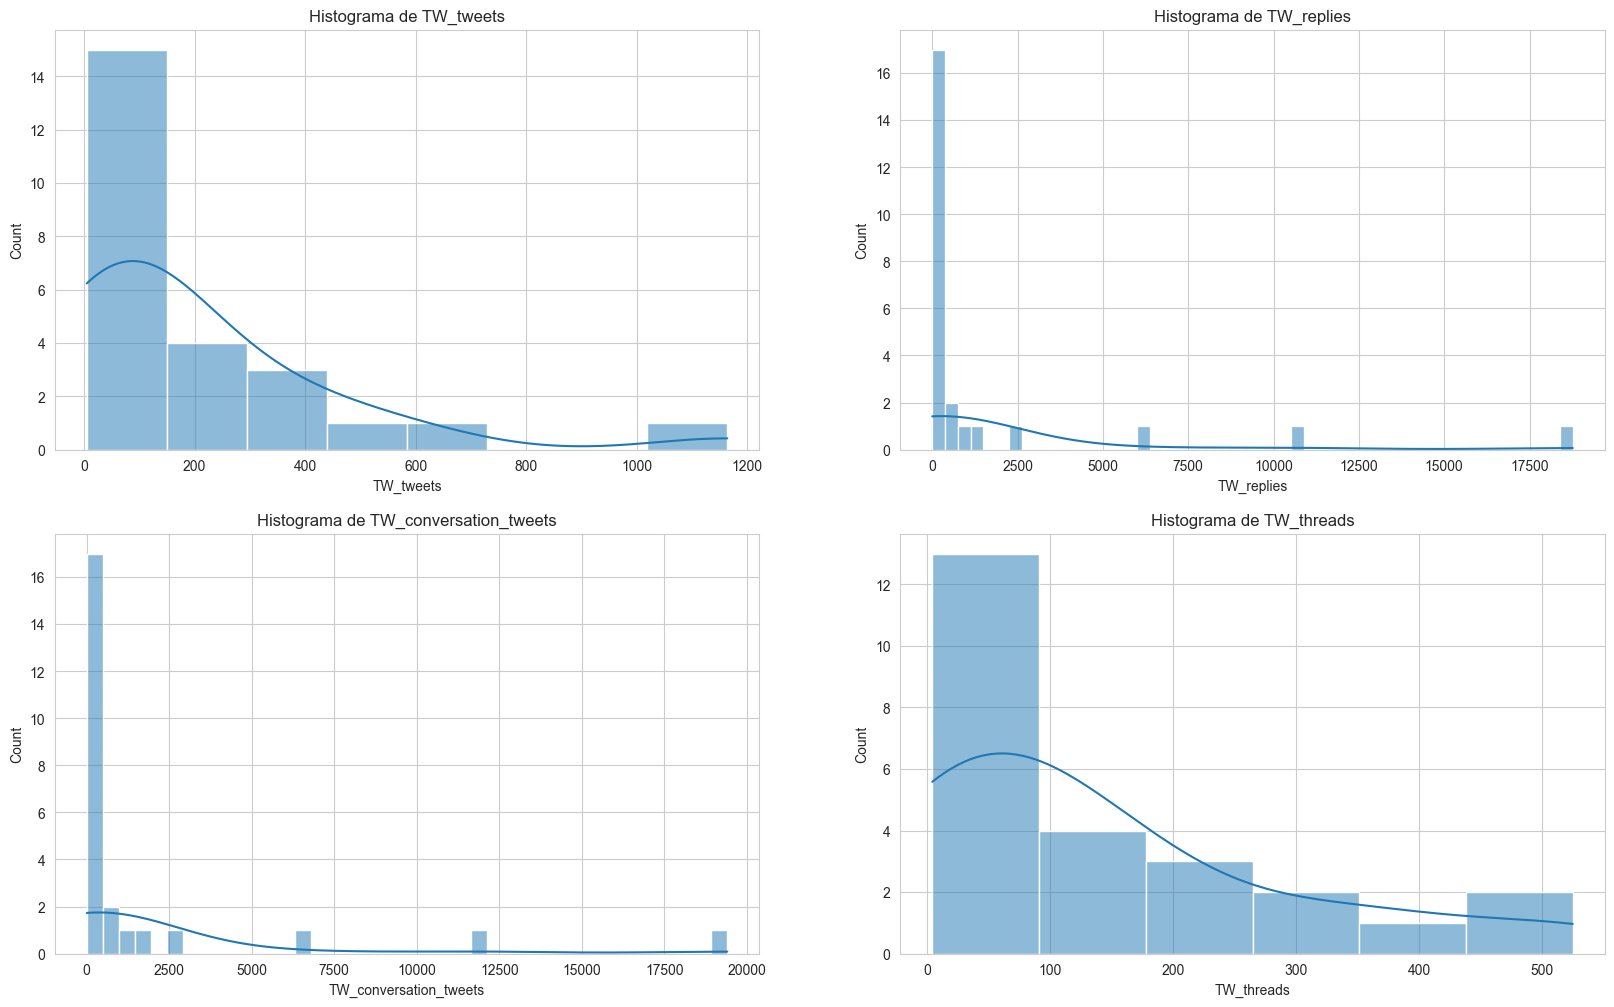

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

sns.histplot(
    cand_df,
    x='TW_tweets',
    kde=True,
    ax=ax[0][0],
).set(title=f'Histograma de TW_tweets')

sns.histplot(
    cand_df,
    x='TW_replies',
    kde=True,
    ax=ax[0][1],
).set(title=f'Histograma de TW_replies')

sns.histplot(
    cand_df,
    x='TW_conversation_tweets',
    kde=True,
    ax=ax[1][0],
).set(title=f'Histograma de TW_conversation_tweets')

sns.histplot(
    cand_df,
    x='TW_threads',
    kde=True,
    ax=ax[1][1],
).set(title=f'Histograma de TW_threads')

Podemos perceber alguns outliers nas quatro métricas, apesar das diferenças serem mais acentuadas em `TW_replies` e `TW_conversation_tweets`. Isso nos mostra que o engajamento recebido pelos usuarios pode ser bastante desigual e irregular, e é provável que isso também impacte nas métricas de conteúdo ofensivo.

### Métricas de conteúdo ofensivo

In [59]:
def get_user_offenses(user):
    """Quantidade de tweets ofensivos postados pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['user'] == user)
    ]
    return offenses.shape[0]

def get_reply_offenses(user):
    """Quantidade de replies ofensivas recebidas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['in_reply_to_user'] == user)
    ]
    return offenses.shape[0]

def get_conversation_offenses(user):
    """Quantidade de tweets ofensivos postados em threads do usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[user_df['class_label'] == True]
    return offenses.shape[0]

cand_df['TW_user_offenses'] = cand_df['TW_USER'].apply(get_user_offenses)
cand_df['TW_reply_offenses'] = cand_df['TW_USER'].apply(get_reply_offenses)
cand_df['TW_conversation_offenses'] = cand_df['TW_USER'].apply(get_conversation_offenses)

cand_df[['TW_user_offenses', 'TW_reply_offenses', 'TW_conversation_offenses']].describe()

,TW_user_offenses,TW_reply_offenses,TW_conversation_offenses
count,25.000000,25.000000,25.000000
mean,13.720000,252.960000,266.480000
std,25.318834,724.875477,741.938796
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000
50%,2.000000,6.000000,10.000000
75%,12.000000,76.000000,97.000000
max,87.000000,3455.000000,3545.000000


[Text(0.5, 1.0, 'Histograma de TW_conversation_offenses')]

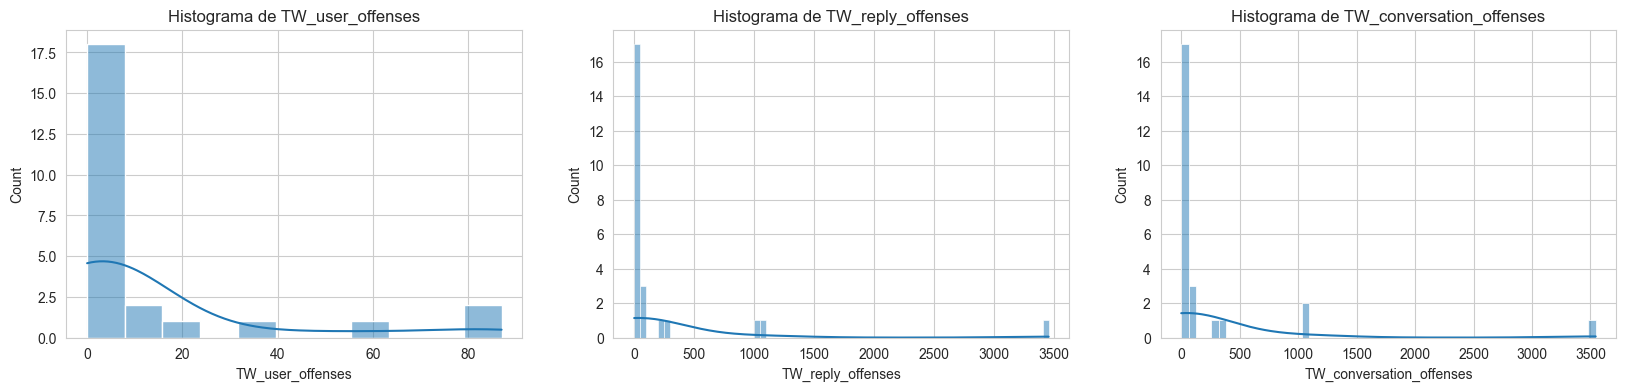

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.histplot(
    cand_df,
    x='TW_user_offenses',
    kde=True,
    ax=ax[0]
).set(title=f'Histograma de TW_user_offenses')

sns.histplot(
    cand_df,
    x='TW_reply_offenses',
    kde=True,
    ax=ax[1]
).set(title=f'Histograma de TW_reply_offenses')

sns.histplot(
    cand_df,
    x='TW_conversation_offenses',
    kde=True,
    ax=ax[2]
).set(title=f'Histograma de TW_conversation_offenses')

Ao analisar a quantidade de conteudo ofensivo encontramos outliers de forma semelhante aos da análise anterior, o que pode apontar uma forte (e já esperada) correlação entre quantidade de tweets e de conteúdo ofensivo.

Vamos agora avaliar esta proporção.

In [66]:
# Taxa de tweets ofensivos pelo total de tweets postados pelo usuário
cand_df['TW_user_offense_rate'] = cand_df['TW_user_offenses'] / cand_df['TW_tweets']

# Taxa de replies ofensivas pelo total de replies recebidas pelo usuário
cand_df['TW_reply_offense_rate'] = cand_df['TW_reply_offenses']/ cand_df['TW_replies']

# Taxa de tweets ofensivos pelo total de tweets em threads do usuário
cand_df['TW_conversation_offense_rate'] = cand_df['TW_conversation_offenses'] / cand_df['TW_conversation_tweets']

cand_df[['TW_user_offense_rate', 'TW_reply_offense_rate', 'TW_conversation_offense_rate']].describe()

,TW_tweets,TW_replies,TW_conversation_tweets,TW_threads
count,25.000000,25.000000,25.000000,25.000000
mean,203.480000,1695.560000,1876.760000,143.640000
std,261.640357,4293.628779,4488.292477,154.821639
min,5.000000,2.000000,7.000000,4.000000
25%,26.000000,42.000000,94.000000,21.000000
50%,110.000000,70.000000,181.000000,86.000000
75%,252.000000,592.000000,814.000000,193.000000
max,1164.000000,18767.000000,19402.000000,525.000000


[Text(0.5, 1.0, 'Histograma de TW_conversation_offense_rate')]

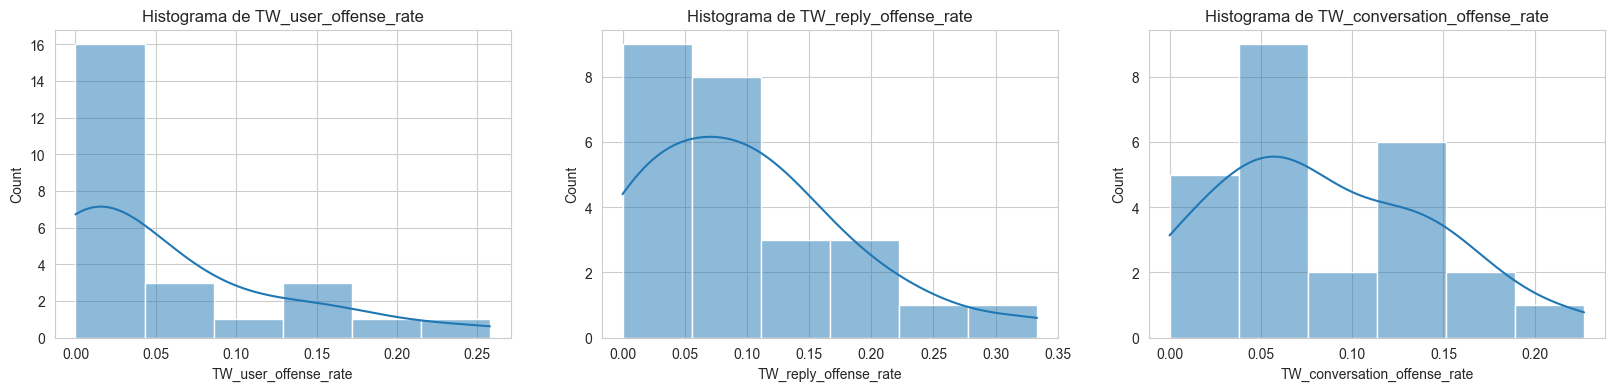

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.histplot(
    cand_df,
    x='TW_user_offense_rate',
    kde=True,
    ax=ax[0]
).set(title=f'Histograma de TW_user_offense_rate')

sns.histplot(
    cand_df,
    x='TW_reply_offense_rate',
    kde=True,
    ax=ax[1]
).set(title=f'Histograma de TW_reply_offense_rate')

sns.histplot(
    cand_df,
    x='TW_conversation_offense_rate',
    kde=True,
    ax=ax[2]
).set(title=f'Histograma de TW_conversation_offense_rate')


Ao considerarmos proporções ao invés de números absolutos as distribuições ficaram mais contínuas, diluindo o impacto dos outliers. Para confirmar o impacto da quantidade de respostas na ocorrência de tweets ofensivos, vamos avaliar também a relação entre os tamanhos das threads

In [92]:
# Média de tweets por thread do usuário
cand_df['TW_thread_avg_length'] = cand_df['TW_conversation_tweets'] / cand_df['TW_threads']

# Taxa de tweets ofensivos postados em threads do usuário pelo total de threads do usuário
cand_df['TW_thread_offense_rate'] = cand_df['TW_conversation_offenses'] / cand_df['TW_threads']

cand_df[['TW_thread_avg_length', 'TW_thread_offense_rate']].describe()

,TW_thread_avg_length,TW_thread_offense_rate
count,25.000000,25.000000
mean,7.019280,0.872916
std,10.159669,1.701362
min,1.013514,0.000000
25%,1.750000,0.098592
50%,2.352601,0.136364
75%,4.600000,0.523810
max,38.419802,7.019802


[Text(0.5, 1.0, 'Histograma de TW_thread_offense_rate')]

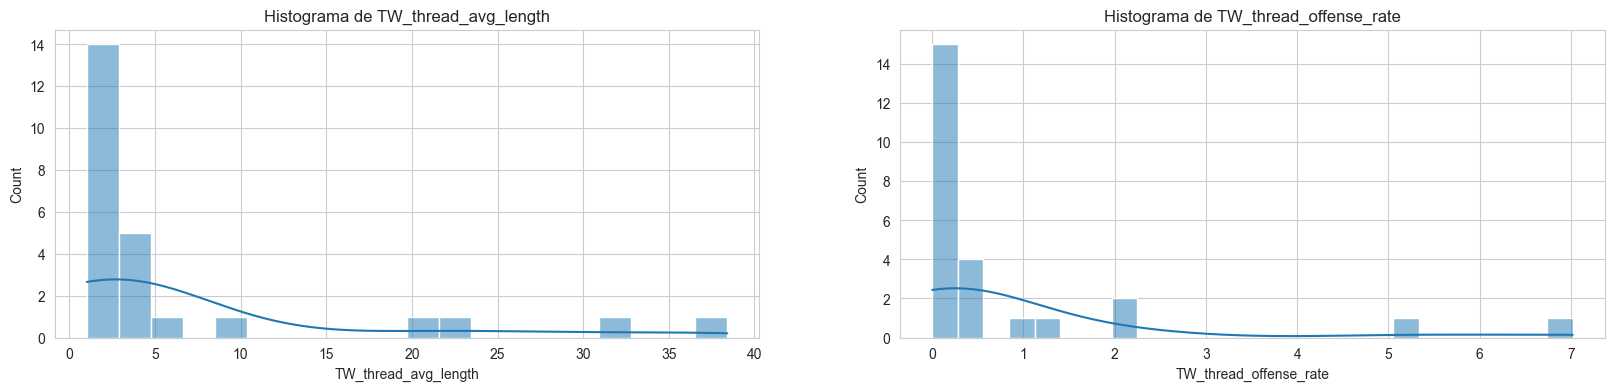

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.histplot(
    cand_df,
    x='TW_thread_avg_length',
    kde=True,
    ax=ax[0]
).set(title=f'Histograma de TW_thread_avg_length')

sns.histplot(
    cand_df,
    x='TW_thread_offense_rate',
    kde=True,
    ax=ax[1]
).set(title=f'Histograma de TW_thread_offense_rate')

Vamos agora avaliar a correlação entre estas variáveis para poder confirmar nossas suspeitas.

<Axes: >

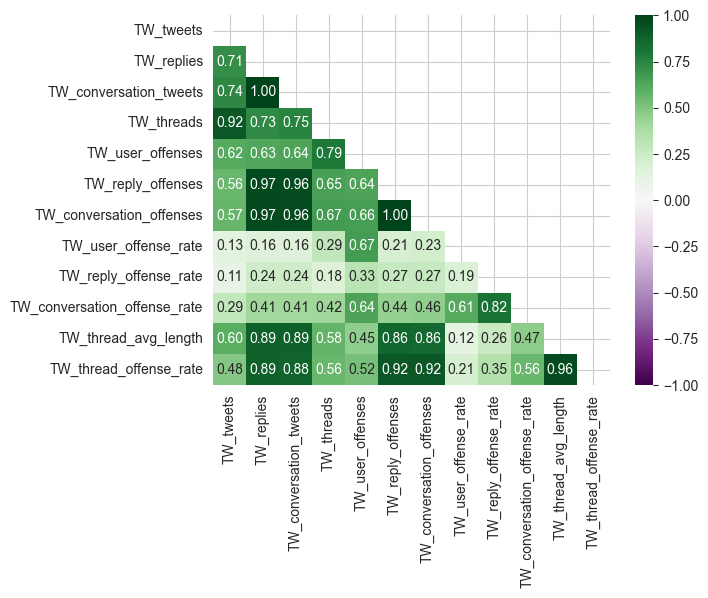

In [95]:
_df = cand_df[[
    'TW_tweets', 'TW_replies', 'TW_conversation_tweets', 'TW_threads', 'TW_user_offenses', 'TW_reply_offenses', 'TW_conversation_offenses',
    'TW_user_offense_rate', 'TW_reply_offense_rate', 'TW_conversation_offense_rate', 'TW_thread_avg_length', 'TW_thread_offense_rate',
]]
sns.heatmap(
    _df.corr(),
    annot=True, fmt='.2f',
    cmap='PRGn', vmin=-1, vmax=1,
    mask=np.triu(np.ones_like(_df.corr()))
)

Como esperado, encontramos correlações muito fortes entre a quantidade de tweets postados e a ocorrência de conteúdo ofensivo, tanto com relação a quantidade de threads abertas, quanto de tamanho das threads.

Mas que outras variáveis também podem estar correlacionadas com o conteúdo ofensivo?

# Analisando outras variáveis

In [ ]:
social_cols = ["DS_GENERO", "DS_COR_RACA", , "DS_GRAU_INSTRUCAO"]

[Text(0.5, 1.0, 'Taxa de ofensas em threads por Gênero')]

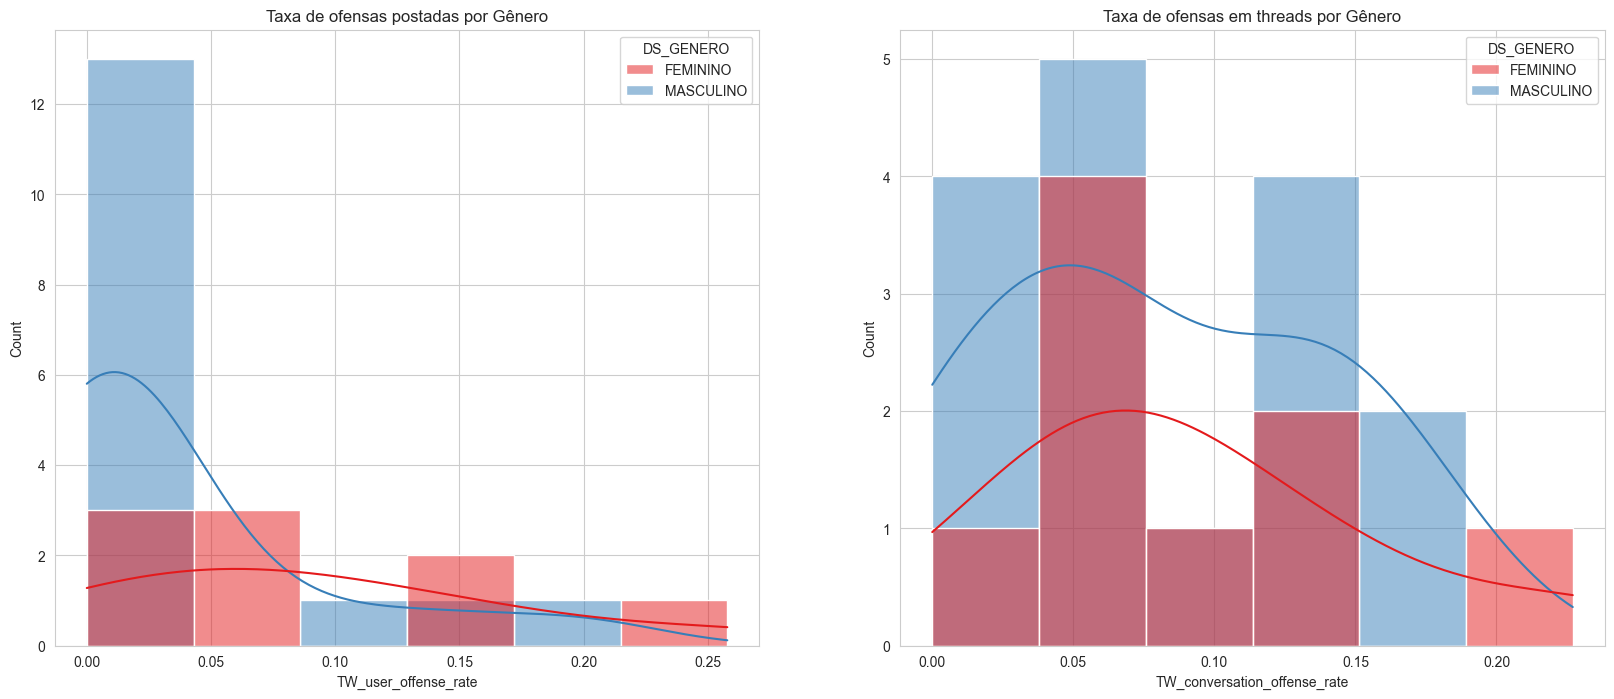

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(
    cand_df,
    x=cand_df['TW_user_offense_rate'], 
    hue='DS_GENERO',
    multiple='layer',
    hue_order=['FEMININO', 'MASCULINO'],
    palette='Set1',
    kde=True,
    ax=ax[0],
).set(title='Taxa de ofensas postadas por Gênero')

sns.histplot(
    cand_df,
    x=cand_df['TW_conversation_offense_rate'], 
    hue='DS_GENERO',
    multiple='layer',
    hue_order=['FEMININO', 'MASCULINO'],
    palette='Set1',
    kde=True,
    ax=ax[1],
).set(title='Taxa de ofensas em threads por Gênero')